In [116]:
import os 
if os.environ.get("preamble_run", None) is not None: 
    print("Not re-runnning preamble")
else: 
    %run -i ../preamble.py

Not re-runnning preamble


In [117]:
import pandas as pd 
import matplotlib.pyplot as plt 
from src.mbpo.util import get_latest_run_dir

In [118]:
# ENV = "HalfCheetah-v4"
ENV = "Hockey-One-v0"
RESULTS_DIR = f"outputs/mbpo/default/gym___{ENV}"

runs = [
    # ("2026.02.04/130615", "real data only"), 
    # ("2026.02.04/130737", "MBPO"),
    # ("2026.02.04/150451", "real data only, fixed alpha=0.3"),
    # ("latest", "latest"),
    # ("2026.02.05/120550", "colored noise, SAC"),
    # ("2026.02.05/120649", "colored noise, MBPO"),
    # ("2026.02.05/131530", "colored noise, SAC, update_frq=1"),
    # ("2026.02.05/134007", "colored noise, SAC, update_frq=1"),
    # ("2026.02.05/151110", "colored noise, MBPO, update_frq=1, horizon=1"),
    # ("2026.02.06/115535", "cn, MBPO, update_f=1, horizon=1, faked reward prediction"),
    # ("2026.02.06/172422", "cn, MBPO, update_f=1, horizon=1, seperate reward prediction"),
    # ("2026.02.10/155958", "cn, MBPO, update_f=10, horizon=1, manual reward calculation"),
    # ("2026.02.10/162533", "cn, MBPO, update_f=10, horizon=1, manual reward calculation w/ closeness to puck"), # no term function yet
    ("2026.02.10/165245", "cn, MBPO, update_f=1, horizon=1, manual reward calculation w/ closeness to puck, term fn"),
]


In [119]:
def get_statistics(run): 
    model_dir = get_latest_run_dir(RESULTS_DIR) if run == "latest" else f"{RESULTS_DIR}/{run}"
    results = pd.read_csv(f"{model_dir}/results.csv")
    if os.path.exists(model_dir+"/model.pth") or os.path.exists(model_dir+"/state_model.pth"): 
        model_train = pd.read_csv(f"{model_dir}/model_train.csv")
        uncertainties = pd.read_csv(f"{model_dir}/env_uncertainty.csv")
    else: 
        model_train = pd.DataFrame(columns=["step", "model_loss", "model_val_score"])
        uncertainties = pd.DataFrame(columns=["step", "alea_uncert_mean", "epis_uncert_mean", "n_rejected_predictions"])
    train = pd.read_csv(f"{model_dir}/train.csv")

    return results, model_train, uncertainties, train 

In [120]:
statistics = {run: get_statistics(run) for run, _ in runs}

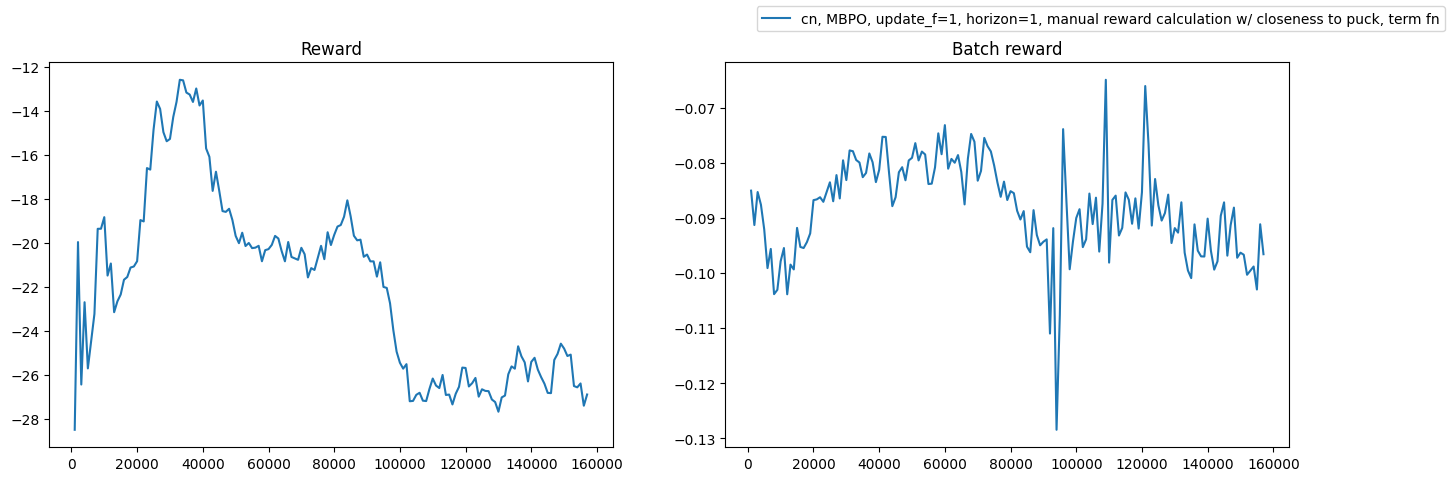

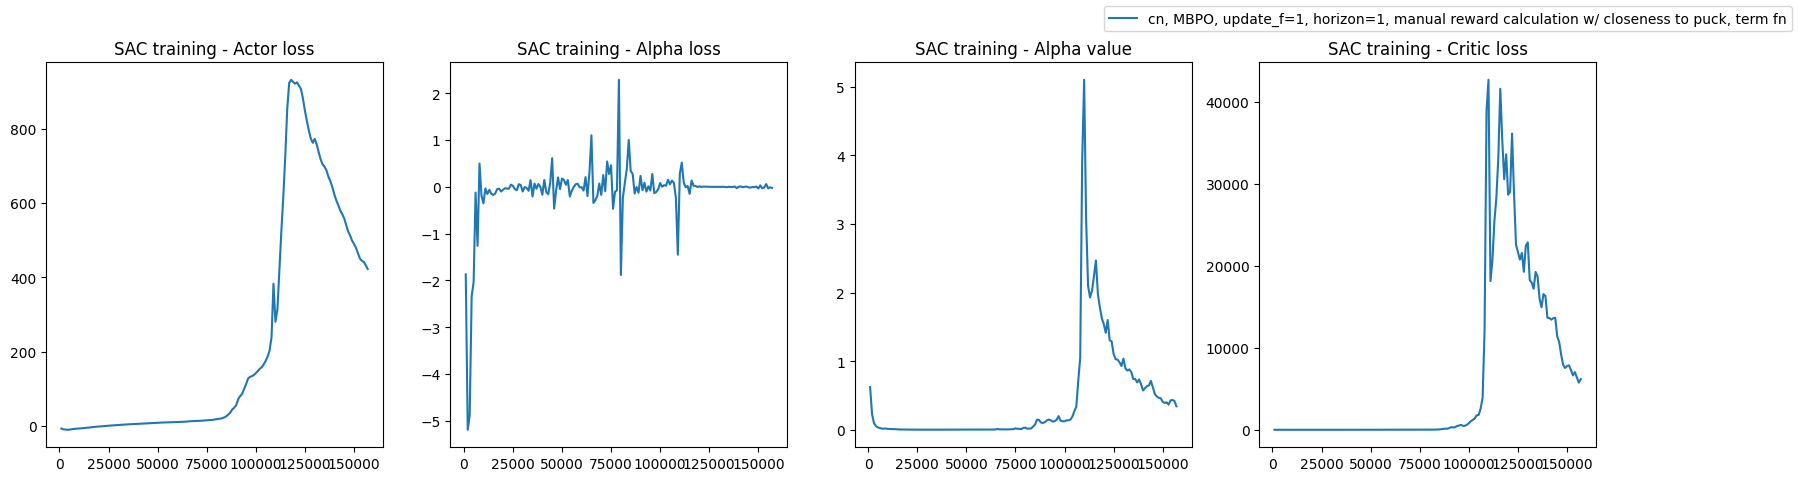

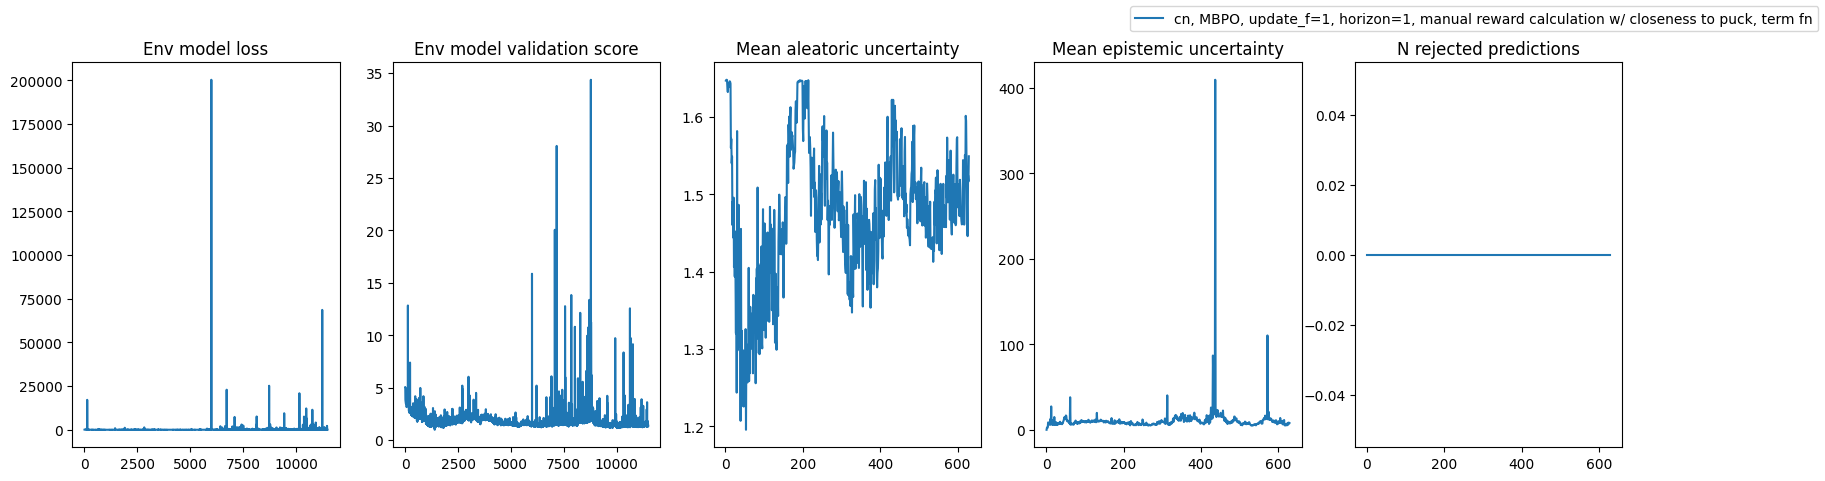

In [121]:
# figs, axs = plt.subplots(5, 2, figsize=(12, 16))

fig_rew, (rew_axis, batch_rew_axis) = plt.subplots(1, 2, figsize=(16, 5))
fig_sac, (sac_axis0, sac_axis1, sac_axis2, sac_axis3) = plt.subplots(1, 4, figsize=(20, 5))
fig_model, (model_axis0, model_axis1, model_axis2, model_axis3, model_axis4) = plt.subplots(1, 5, figsize=(20, 5))

figs = [fig_rew, fig_sac, fig_model]
# env_model_axis0 = axs[1, 1]
# env_model_axis1 = axs[2, 1]
# uncert_axis = axs[3, 1]
# uncert_axis2 = axs[4, 1]

for run_id, run_name in runs: 
    results, model_train, uncertainties, train = statistics[run_id]

    rew_axis.set_title("Reward")
    results["smoothed_reward"] = results['episode_reward'].rolling(window=20, min_periods=1).mean()
    rew_axis.plot(results['env_step'], results['smoothed_reward'], label=run_name)

    sac_axis0.set_title("SAC training - Actor loss")
    sac_axis0.plot(train['step'], train['actor_loss'], label=run_name)
    
    sac_axis1.set_title("SAC training - Alpha loss")
    sac_axis1.plot(train['step'], train['alpha_loss'], label=run_name)

    sac_axis2.set_title("SAC training - Alpha value")
    sac_axis2.plot(train['step'], train['alpha_value'], label=run_name)

    sac_axis3.set_title("SAC training - Critic loss")
    sac_axis3.plot(train['step'], train['critic_loss'], label=run_name)

    batch_rew_axis.set_title("Batch reward")
    batch_rew_axis.plot(train['step'], train['batch_reward'], label=run_name)

    model_axis0.set_title("Env model loss")
    model_axis0.plot(model_train['step'], model_train['model_loss'], label=run_name)

    model_axis1.set_title("Env model validation score")
    model_axis1.plot(model_train['step'], model_train['model_val_score'], label=run_name)


    model_axis2.set_title("Mean aleatoric uncertainty")
    model_axis2.plot(uncertainties['step'], uncertainties['alea_uncert_mean'], label=run_name)

    model_axis3.set_title("Mean epistemic uncertainty")
    model_axis3.plot(uncertainties['step'], uncertainties['epis_uncert_mean'], label=run_name)
    
    model_axis4.set_title("N rejected predictions")
    model_axis4.plot(uncertainties['step'], uncertainties['n_rejected_predictions'], label=run_name)

[f.legend([run_name for _, run_name in runs]) for f in figs]
None